# Benchmarking Baseline Performance

In [49]:
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [18]:
sns.set_theme()
sns.set_style("whitegrid")
plt.style.use("alan.mplstyle")

In [89]:
da = pickle.load(open("../gemma-2-2b-add-acc.pkl", "rb"))

In [114]:
def parse_answer(result: str):
    """Given the causal response from a language model parse the problem
    it was required to solve using regex.

    Args: 
        result (str): Resulting output from a LM.
    Returns:
        a tuple of three integers (a, b, ans) where the given question to
        LM was `a + b = ` and the LM's response was `ans`. 
    """
    ptrn = r"(-?\d+)\s+\-\s+(-?\d+)\s+=\s+(-?\d+)"
    srch = re.search(ptrn, result.split("\n")[2])
    if srch is not None:
        return (
            int(srch.group(1)),
            int(srch.group(2)),
            int(srch.group(3))
        )
    else:
        # get the problem
        ptrn = r"(-?\d+)\s+\-\s+(-?\d+)"
        srch = re.search(ptrn, result.split("\n")[2])
        return (
            int(srch.group(1)),
            int(srch.group(2)),
            -np.inf
        )


In [147]:
ds = pickle.load(open("../gemma-2-9b-sub-benchmark.pkl", "rb"))

In [148]:
ds[(2,4)][0]

'52 - 3168 = -3116\n77 - 9390 = -9313\n13 - 7655 = 7642\n12 - 12 = 0\n'

In [149]:
dp = {k: [parse_answer(j) for j in v] for k, v in ds.items()}

In [150]:
da = {k: sum([1 if abs(v[0] - v[1]) == abs(v[2]) else 0 for v in j]) / len(j) for k,j in dp.items()} 

In [151]:
grid = np.zeros((8,8))

In [152]:
for k, v in da.items():
    grid[k[0]-1,k[1]-1] = v

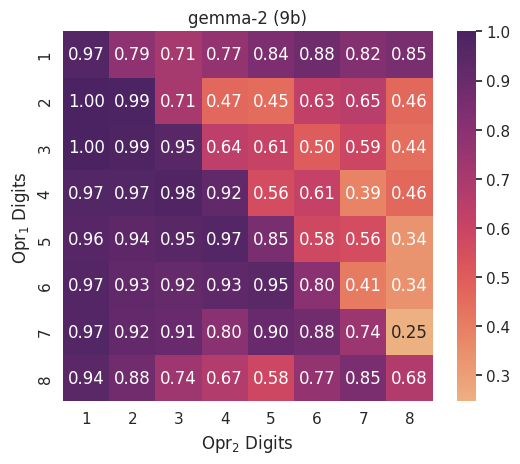

In [153]:
ax = sns.heatmap(grid, cmap="flare", annot=True, fmt=".2f", square=True, cbar=True)
ax.set_xticklabels(range(1,9))
ax.set_yticklabels(range(1,9))
ax.set_title("gemma-2 (9b)")
ax.set_ylabel("Opr$_1$ Digits")
ax.set_xlabel("Opr$_2$ Digits")
plt.savefig("../figures/gemma-2-9b-sub-benchmark.pdf")

In [17]:
d[(1,1)][0].split("\n")

['5 - 2 = 3', '1 - 3 = -2', '2 - 3 = 1', '3 - 1 = 2', '4 - 2 =']

In [79]:
da = {k: [1 if v[0] + v[1] == v[2] else 0 for v in j] for k, j in dp.items()} 

In [82]:
ds = {k: sum(v) / len(v) for k,v in da.items()}

In [84]:
pickle.dump(ds, open("gemma-2-2b-sub-acc.pkl", "wb"))